# Importation des bibliotheques

In [24]:
import pandas as pd
import numpy as np
import os
import re
import random
import shutil
from collections import defaultdict
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from timm import create_model
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import time 

## Verification du GPU

In [2]:
print("GPU disponible :", torch.cuda.is_available())
print("Nom du GPU :", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "Aucun")


GPU disponible : False
Nom du GPU : Aucun


# Importation des données

In [3]:
base_path = r"C:\Users\Christian\Desktop\ClassificationInvertebresMarrins\Dataset\train"

In [4]:
print("le contenu du dossier de base est:")
print(os.listdir(base_path))

le contenu du dossier de base est:
['Actiniaria_', 'Actinoptilum_molle_', 'Actinoscyphia_plebeia_', 'Actinostola_capensis_', 'Aequorea_spp_', 'Africolaria_rutila_', 'Alcyonacea_', 'Amalda_bullioides_', 'Anthoptilum_grandiflorum_', 'Aphelodoris_sp__', 'Aphrodita_alta_', 'Aristeus_varidens_', 'Armina_sp__', 'Ascidiacea_', 'Astropecten_irregularis_pontoporeus_', 'Athleta_abyssicola_', 'Athleta_lutosa_', 'Bolocera_kerguelensis_', 'Brissopsis_lyrifera_capensis_', 'Bryozoa_', 'Cavernularia_spp_', 'Cephalodiscus_gilchristi_', 'Ceramaster_patagonicus_euryplax_', 'Charonia_lampas_', 'Cheilostomatida_', 'Cheiraster_hirsutus_', 'Chondraster_elattosis_', 'Chrysaora_fulgida_', 'Chrysaora_spp_', 'Comanthus_wahlbergii_', 'Comitas_saldanhae_', 'Comitas_stolida_', 'Cosmasterias_felipes_', 'Crossaster_penicillatus_', 'Cypraeovula_iutsui_', 'Diplopteraster_multipes_', 'Dipsacaster_sladeni_capensis_', 'Echinus_gilchristi_', 'Eleutherobia_variable_', 'Euspira_napus_', 'Exodromidia_spinosa_', 'Exodromidia_s

In [5]:
"""# Chemin vers le dossier InvertebresMarrins
invertebres_path = "/kaggle/input/invertebresmarrins/InvertebresMarrins"
invertebres_path = os.path.join(invertebres_path, "train_small")

# Vérification que le chemin existe
if not os.path.exists(invertebres_path):
    print("Erreur : Le dossier train_small n'existe pas à l'emplacement spécifié.")
    print("Contenu du dossier InvertebresMarrins :")
    print(os.listdir(invertebres_path))
else:
    print("Dossier InvertebresMarrins trouvé avec succès !")"""

'# Chemin vers le dossier InvertebresMarrins\ninvertebres_path = "/kaggle/input/invertebresmarrins/InvertebresMarrins"\ninvertebres_path = os.path.join(invertebres_path, "train_small")\n\n# Vérification que le chemin existe\nif not os.path.exists(invertebres_path):\n    print("Erreur : Le dossier train_small n\'existe pas à l\'emplacement spécifié.")\n    print("Contenu du dossier InvertebresMarrins :")\n    print(os.listdir(invertebres_path))\nelse:\n    print("Dossier InvertebresMarrins trouvé avec succès !")'

In [8]:
if os.path.exists(base_path):
    # Lister tous les sous-dossiers (classes)
    classes = [d for d in os.listdir(base_path) 
              if os.path.isdir(os.path.join(base_path, d))]

In [9]:
print("\nNombre d'images par classe :")
print("----------------------------")
for class_name in classes:
    class_path = os.path.join(base_path, class_name)
    num_images = len([f for f in os.listdir(class_path) 
                     if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        
    print(f"{class_name}: {num_images} images")


Nombre d'images par classe :
----------------------------
Actiniaria_: 29 images
Actinoptilum_molle_: 9 images
Actinoscyphia_plebeia_: 9 images
Actinostola_capensis_: 8 images
Aequorea_spp_: 19 images
Africolaria_rutila_: 8 images
Alcyonacea_: 10 images
Amalda_bullioides_: 20 images
Anthoptilum_grandiflorum_: 17 images
Aphelodoris_sp__: 9 images
Aphrodita_alta_: 9 images
Aristeus_varidens_: 22 images
Armina_sp__: 12 images
Ascidiacea_: 11 images
Astropecten_irregularis_pontoporeus_: 34 images
Athleta_abyssicola_: 24 images
Athleta_lutosa_: 22 images
Bolocera_kerguelensis_: 22 images
Brissopsis_lyrifera_capensis_: 25 images
Bryozoa_: 13 images
Cavernularia_spp_: 15 images
Cephalodiscus_gilchristi_: 8 images
Ceramaster_patagonicus_euryplax_: 9 images
Charonia_lampas_: 10 images
Cheilostomatida_: 9 images
Cheiraster_hirsutus_: 20 images
Chondraster_elattosis_: 8 images
Chrysaora_fulgida_: 18 images
Chrysaora_spp_: 12 images
Comanthus_wahlbergii_: 12 images
Comitas_saldanhae_: 36 images
C

In [10]:
base_path

'C:\\Users\\Christian\\Desktop\\ClassificationInvertebresMarrins\\Dataset\\train'

In [11]:
# Chemins
input_path = base_path  # Chemin d'origine en lecture seule
working_path = "C:\\Users\\Christian\\Desktop\\ClassificationInvertebresMarrins\\Dataset\\renamed_data"  # Chemin où nous pouvons écrire

# Créer le dossier de travail
os.makedirs(working_path, exist_ok=True)

# Dictionnaire pour stocker les fichiers par classe
fichiers_par_classe = {}

# Parcourir toutes les classes
for class_name in os.listdir(input_path):
    class_input_path = os.path.join(input_path, class_name)
    class_output_path = os.path.join(working_path, class_name)
    
    # Vérifier que c'est bien un dossier et créer le dossier de sortie
    if os.path.isdir(class_input_path):
        os.makedirs(class_output_path, exist_ok=True)
        fichiers_par_classe[class_name] = []
        
        # Parcourir les images de la classe
        for i, file_name in enumerate(os.listdir(class_input_path)):
            if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                # Nouveau nom de fichier
                file_ext = os.path.splitext(file_name)[1]
                new_name = f"{class_name}_{i}{file_ext}"
                
                # Chemins complets
                old_path = os.path.join(class_input_path, file_name)
                new_path = os.path.join(class_output_path, new_name)
                
                # Copier le fichier avec le nouveau nom
                shutil.copy2(old_path, new_path)
                
                # Ajouter au dictionnaire
                fichiers_par_classe[class_name].append(new_name)

# Afficher le résultat
fichiers_par_classe

{'Actiniaria_': ['Actiniaria__0.jpeg',
  'Actiniaria__1.jpeg',
  'Actiniaria__2.jpeg',
  'Actiniaria__3.jpeg',
  'Actiniaria__4.jpeg',
  'Actiniaria__5.jpeg',
  'Actiniaria__6.jpeg',
  'Actiniaria__7.jpeg',
  'Actiniaria__8.jpeg',
  'Actiniaria__9.jpeg',
  'Actiniaria__10.jpeg',
  'Actiniaria__11.jpeg',
  'Actiniaria__12.jpeg',
  'Actiniaria__13.jpeg',
  'Actiniaria__14.jpeg',
  'Actiniaria__15.jpeg',
  'Actiniaria__16.jpeg',
  'Actiniaria__17.jpeg',
  'Actiniaria__18.jpeg',
  'Actiniaria__19.jpeg',
  'Actiniaria__20.jpeg',
  'Actiniaria__21.jpeg',
  'Actiniaria__22.jpeg',
  'Actiniaria__23.jpeg',
  'Actiniaria__24.jpeg',
  'Actiniaria__25.jpeg',
  'Actiniaria__26.jpeg',
  'Actiniaria__27.jpeg',
  'Actiniaria__28.jpeg'],
 'Actinoptilum_molle_': ['Actinoptilum_molle__0.jpeg',
  'Actinoptilum_molle__1.jpeg',
  'Actinoptilum_molle__2.jpeg',
  'Actinoptilum_molle__3.jpeg',
  'Actinoptilum_molle__4.jpeg',
  'Actinoptilum_molle__5.jpeg',
  'Actinoptilum_molle__6.jpeg',
  'Actinoptilum_molle_

In [12]:
"""if os.path.exists(output_path):
    shutil.rmtree(output_path)
    print(f"Le dossier existant {output_path} a été supprimé.")"""

'if os.path.exists(output_path):\n    shutil.rmtree(output_path)\n    print(f"Le dossier existant {output_path} a été supprimé.")'

In [14]:
# Puis recréer les dossiers vides
output_path = r'C:\Users\Christian\Desktop\ClassificationInvertebresMarrins\Dataset\split_data'
os.makedirs(f"{output_path}/train", exist_ok=True)
os.makedirs(f"{output_path}/val", exist_ok=True)
os.makedirs(f"{output_path}/test", exist_ok=True)

# Decoupage en 80/10/10

In [20]:
# Chemins
input_path = "C:\\Users\\Christian\\Desktop\\ClassificationInvertebresMarrins\\Dataset\\renamed_data"  # Chemin où nous pouvons écrire# Chemin des images renommées
output_path = r'C:\Users\Christian\Desktop\ClassificationInvertebresMarrins\Dataset\split_data'   # Chemin pour les données divisées

# Parcourir chaque classe (maintenant dans le dossier renamed_data)
for class_name in os.listdir(input_path):
    class_path = os.path.join(input_path, class_name)
    
    # Vérifier que c'est bien un dossier
    if not os.path.isdir(class_path):
        continue
    
    # Lister toutes les images (déjà renommées)
    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    # Vérifier qu'il y a assez d'images pour le split
    if len(images) < 5:  # Vous pouvez ajuster ce seuil
        print(f"Attention: la classe {class_name} a seulement {len(images)} images")
        continue
    
    # Première séparation: 80% train, 20% temp
    train_files, temp_files = train_test_split(
        images,
        test_size=0.2,
        random_state=42
    )
    
    # Deuxième séparation: 50% val, 50% test (10% chacun du total)
    val_files, test_files = train_test_split(
        temp_files,
        test_size=0.5,
        random_state=42
    )
    
    # Créer les sous-dossiers de classe
    os.makedirs(f"{output_path}/train/{class_name}", exist_ok=True)
    os.makedirs(f"{output_path}/val/{class_name}", exist_ok=True)
    os.makedirs(f"{output_path}/test/{class_name}", exist_ok=True)
    
    # Fonction pour copier les fichiers
    def copy_files(files, subset):
        for file in files:
            src = os.path.join(class_path, file)
            dst = f"{output_path}/{subset}/{class_name}/{file}"
            shutil.copy2(src, dst)
    
    # Copier les fichiers
    copy_files(train_files, "train")
    copy_files(val_files, "val")
    copy_files(test_files, "test")

# Statistiques finales
print("\nDivision terminée ! Statistiques par classe:")
for class_name in os.listdir(input_path):
    if os.path.isdir(os.path.join(input_path, class_name)):
        print(f"\nClasse: {class_name}")
        print(f"Train: {len(os.listdir(f'{output_path}/train/{class_name}'))} images")
        print(f"Validation: {len(os.listdir(f'{output_path}/val/{class_name}'))} images")
        print(f"Test: {len(os.listdir(f'{output_path}/test/{class_name}'))} images")


Division terminée ! Statistiques par classe:

Classe: Actiniaria_
Train: 23 images
Validation: 3 images
Test: 3 images

Classe: Actinoptilum_molle_
Train: 7 images
Validation: 1 images
Test: 1 images

Classe: Actinoscyphia_plebeia_
Train: 7 images
Validation: 1 images
Test: 1 images

Classe: Actinostola_capensis_
Train: 6 images
Validation: 1 images
Test: 1 images

Classe: Aequorea_spp_
Train: 15 images
Validation: 2 images
Test: 2 images

Classe: Africolaria_rutila_
Train: 6 images
Validation: 1 images
Test: 1 images

Classe: Alcyonacea_
Train: 8 images
Validation: 1 images
Test: 1 images

Classe: Amalda_bullioides_
Train: 16 images
Validation: 2 images
Test: 2 images

Classe: Anthoptilum_grandiflorum_
Train: 13 images
Validation: 2 images
Test: 2 images

Classe: Aphelodoris_sp__
Train: 7 images
Validation: 1 images
Test: 1 images

Classe: Aphrodita_alta_
Train: 7 images
Validation: 1 images
Test: 1 images

Classe: Aristeus_varidens_
Train: 17 images
Validation: 2 images
Test: 3 imag

In [21]:
output_path

'C:\\Users\\Christian\\Desktop\\ClassificationInvertebresMarrins\\Dataset\\split_data'

# Pretraitement

Classes disponibles :
Indice 0 : Actiniaria_
Indice 1 : Actinoptilum_molle_
Indice 2 : Actinoscyphia_plebeia_
Indice 3 : Actinostola_capensis_
Indice 4 : Aequorea_spp_
Indice 5 : Africolaria_rutila_
Indice 6 : Alcyonacea_
Indice 7 : Amalda_bullioides_
Indice 8 : Anthoptilum_grandiflorum_
Indice 9 : Aphelodoris_sp__
Indice 10 : Aphrodita_alta_
Indice 11 : Aristeus_varidens_
Indice 12 : Armina_sp__
Indice 13 : Ascidiacea_
Indice 14 : Astropecten_irregularis_pontoporeus_
Indice 15 : Athleta_abyssicola_
Indice 16 : Athleta_lutosa_
Indice 17 : Bolocera_kerguelensis_
Indice 18 : Brissopsis_lyrifera_capensis_
Indice 19 : Bryozoa_
Indice 20 : Cavernularia_spp_
Indice 21 : Cephalodiscus_gilchristi_
Indice 22 : Ceramaster_patagonicus_euryplax_
Indice 23 : Charonia_lampas_
Indice 24 : Cheilostomatida_
Indice 25 : Cheiraster_hirsutus_
Indice 26 : Chondraster_elattosis_
Indice 27 : Chrysaora_fulgida_
Indice 28 : Chrysaora_spp_
Indice 29 : Comanthus_wahlbergii_
Indice 30 : Comitas_saldanhae_
Indice 

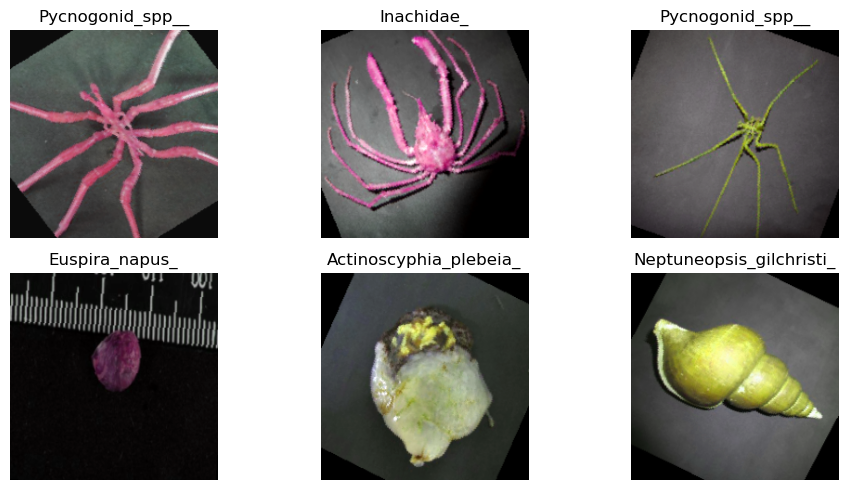

In [26]:
# -----------------------------
# PARAMÈTRES GÉNÉRAUX
# -----------------------------
IMG_SIZE = 224
BATCH_SIZE = 32
DATA_DIR = r'C:\Users\Christian\Desktop\ClassificationInvertebresMarrins\Dataset\split_data'  # <-- adapte ce chemin selon ton dataset sur Kaggle

TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VAL_DIR = os.path.join(DATA_DIR, 'val')  # ou 'test' si tu n'as pas de val

# -----------------------------
# TRANSFORMATIONS
# -----------------------------

# Augmentation + prétraitement pour l'entraînement
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(degrees=40),
    transforms.RandomResizedCrop(size=IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Prétraitement uniquement pour validation / test
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# -----------------------------
# DATASETS
# -----------------------------
train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=train_transform)
val_dataset = datasets.ImageFolder(root=VAL_DIR, transform=val_transform)

# -----------------------------
# DATALOADERS
# -----------------------------
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# -----------------------------
# AFFICHAGE DES CLASSES
# -----------------------------
class_to_idx = train_dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

print("Classes disponibles :")
for idx, class_name in idx_to_class.items():
    print(f"Indice {idx} : {class_name}")

# -----------------------------
# VÉRIFICATION D'UN BATCH
# -----------------------------
images, labels = next(iter(train_loader))
print("Shape des images :", images.shape)  # [batch_size, 3, 224, 224]
print("Shape des labels :", labels.shape)

# -----------------------------
# AFFICHER QUELQUES IMAGES POUR VÉRIFIER
# -----------------------------
def imshow(img, title):
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    img = torch.clamp(img, 0, 1)
    plt.imshow(img.permute(1, 2, 0).numpy())
    plt.title(title)
    plt.axis('off')

plt.figure(figsize=(10, 5))
for i in range(6):
    plt.subplot(2, 3, i+1)
    imshow(images[i], title=idx_to_class[labels[i].item()])
plt.tight_layout()
plt.show()


# Chargement du modele et entrainement 

In [ ]:
"""# Vérification du device (GPU si dispo)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device utilisé :", device)

# Charger le modèle ViT pré-entraîné depuis timm avec 137 classes
model = create_model('vit_base_patch16_224', pretrained=True)
model.head = nn.Linear(model.head.in_features, 137)
model = model.to(device)

# Définir l'optimiseur et la fonction de perte
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)"""


In [ ]:
"""# Entraînement du modèle
NUM_EPOCHS = 10

for epoch in range(NUM_EPOCHS):  
    model.train()  # Mode entraînement
    start_time = time.time()

    correct_train = 0
    total_train = 0
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        running_loss += loss.item() * images.size(0)

    train_accuracy = 100 * correct_train / total_train
    avg_loss = running_loss / total_train
    epoch_time = time.time() - start_time

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] - Loss: {avg_loss:.4f} - Accuracy: {train_accuracy:.2f}% - Time: {epoch_time:.2f}s")
"""

# Sauvegarde du model

In [ ]:
"""torch.save(model.state_dict(), "/kaggle/working/vit_model1.pth")"""


In [ ]:
"""# -----------------------------
# PARAMÈTRES GÉNÉRAUX
# -----------------------------
IMG_SIZE = 224
BATCH_SIZE = 32
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# -----------------------------
# CHARGEMENT DU MODÈLE
# -----------------------------
from timm import create_model
import torch.nn as nn

model = create_model('vit_base_patch16_224', pretrained=False, num_classes=137)
model.load_state_dict(torch.load('/kaggle/working/vit_model1.pth', map_location=DEVICE))  # <-- adapte le chemin
model = model.to(DEVICE)
model.eval()

# -----------------------------
# TRANSFORM POUR TEST
# -----------------------------
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# -----------------------------
# CHARGEMENT DES DONNÉES DE TEST
# -----------------------------
test_data_dir = '/kaggle/working/split_data/test'
test_dataset = datasets.ImageFolder(root=test_data_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

idx_to_class = {v: k for k, v in test_dataset.class_to_idx.items()}
"""

In [ ]:
"""# -----------------------------
# ÉVALUATION
# -----------------------------
all_preds = []
all_labels = []

correct_test = 0
total_test = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


In [ ]:
"""# -----------------------------
# MÉTRIQUES
# -----------------------------
test_accuracy = 100 * correct_test / total_test
print(f'Test Accuracy: {test_accuracy:.2f}%')

y_true = np.array(all_labels)
y_pred = np.array(all_preds)

# Si tes noms de classes sont des noms réels :
class_names = [idx_to_class[i] for i in range(len(idx_to_class))]

report = classification_report(
    y_true, y_pred, target_names=class_names, output_dict=True, zero_division=0
)

In [ ]:
"""# -----------------------------
# CLASSES À FAIBLE/MOYENNE PRÉCISION
# -----------------------------
print("\nClasses avec précision ≤ 25%:")
for class_name, metrics in report.items():
    if isinstance(metrics, dict) and metrics['precision'] <= 0.25:
        print(f"Classe: {class_name}, Précision: {metrics['precision']:.2f}, "
              f"Rappel: {metrics['recall']:.2f}, Support: {int(metrics['support'])}")

print("\nClasses avec précision > 25% et ≤ 50%:")
for class_name, metrics in report.items():
    if isinstance(metrics, dict) and 0.25 < metrics['precision'] <= 0.50:
        print(f"Classe: {class_name}, Précision: {metrics['precision']:.2f}, "
              f"Rappel: {metrics['recall']:.2f}, Support: {int(metrics['support'])}")


In [ ]:
"""# -----------------------------
# MATRICE DE CONFUSION & ERREURS
# -----------------------------
conf_matrix = confusion_matrix(y_true, y_pred)

print("\nErreurs de classification :")
for i, (true, pred) in enumerate(zip(y_true, y_pred)):
    if true != pred:
        print(f"Image {i} : Vraie = {class_names[true]}, Prédite = {class_names[pred]}")

print("\nImages bien classées :")
for i, (true, pred) in enumerate(zip(y_true, y_pred)):
    if true == pred:
        print(f"Image {i} : Vraie = {class_names[true]}, Prédite = {class_names[pred]}")


# entrainement 2

In [27]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device utilisé :", device)

# Modèle
model = create_model('vit_base_patch16_224', pretrained=True)
model.head = nn.Linear(model.head.in_features, 137)
model = model.to(device)

# Fonction de perte, optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Suivi des métriques
NUM_EPOCHS = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
val_f1_scores = []

for epoch in range(NUM_EPOCHS):
    model.train()
    start_time = time.time()

    correct_train, total_train, running_loss = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        running_loss += loss.item() * images.size(0)

    train_acc = 100 * correct_train / total_train
    avg_train_loss = running_loss / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # --- Évaluation sur validation ---
    model.eval()
    val_loss, correct_val, total_val = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_acc = 100 * correct_val / total_val
    avg_val_loss = val_loss / total_val
    f1 = f1_score(all_labels, all_preds, average='weighted')

    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)
    val_f1_scores.append(f1)

    epoch_time = time.time() - start_time
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] - "
          f"Train Loss: {avg_train_loss:.4f} - Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {avg_val_loss:.4f} - Val Acc: {val_acc:.2f}% | "
          f"F1 Score: {f1:.4f} - Time: {epoch_time:.2f}s")


Device utilisé : cpu
Epoch [1/10] - Train Loss: 3.5316 - Train Acc: 25.00% | Val Loss: 1.7603 - Val Acc: 53.53% | F1 Score: 0.4755 - Time: 2481.87s
Epoch [2/10] - Train Loss: 1.2099 - Train Acc: 66.68% | Val Loss: 1.2295 - Val Acc: 65.56% | F1 Score: 0.6038 - Time: 2294.56s
Epoch [3/10] - Train Loss: 0.4262 - Train Acc: 86.79% | Val Loss: 0.9437 - Val Acc: 76.35% | F1 Score: 0.7407 - Time: 2283.49s
Epoch [4/10] - Train Loss: 0.2886 - Train Acc: 92.21% | Val Loss: 0.7658 - Val Acc: 79.67% | F1 Score: 0.7718 - Time: 2387.04s
Epoch [5/10] - Train Loss: 0.2258 - Train Acc: 93.63% | Val Loss: 0.7556 - Val Acc: 83.82% | F1 Score: 0.8132 - Time: 2833.13s
Epoch [6/10] - Train Loss: 0.1212 - Train Acc: 96.42% | Val Loss: 0.8532 - Val Acc: 80.50% | F1 Score: 0.7744 - Time: 2512.63s
Epoch [7/10] - Train Loss: 0.1292 - Train Acc: 96.42% | Val Loss: 0.8357 - Val Acc: 79.67% | F1 Score: 0.7506 - Time: 2721.67s
Epoch [8/10] - Train Loss: 0.1043 - Train Acc: 97.32% | Val Loss: 0.8192 - Val Acc: 82.16%

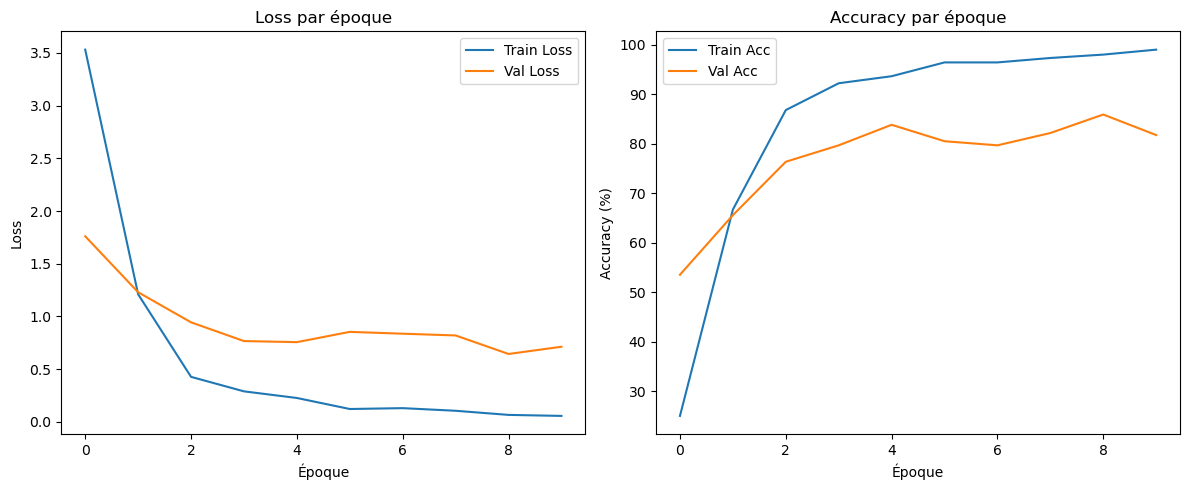

In [28]:
# --- COURBES DE PRÉCISION ET DE PERTE ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss par époque')
plt.xlabel('Époque')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.title('Accuracy par époque')
plt.xlabel('Époque')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


In [31]:
torch.save(model.state_dict(), r"C:\Users\Christian\Desktop\ClassificationInvertebresMarrins\best_model.pth")

# evaluation

In [33]:
# -----------------------------
# PARAMÈTRES GÉNÉRAUX
# -----------------------------
IMG_SIZE = 224
BATCH_SIZE = 32
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# -----------------------------
# CHARGEMENT DU MODÈLE
# -----------------------------
from timm import create_model

model = create_model('vit_base_patch16_224', pretrained=False, num_classes=137)
model.load_state_dict(torch.load(r"C:\Users\Christian\Desktop\ClassificationInvertebresMarrins\best_model.pth", map_location=DEVICE))
model = model.to(DEVICE)
model.eval()

# -----------------------------
# TRANSFORM POUR TEST
# -----------------------------
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# -----------------------------
# CHARGEMENT DES DONNÉES DE TEST
# -----------------------------
test_data_dir = r"C:\Users\Christian\Desktop\ClassificationInvertebresMarrins\dataset\split_data\test"
test_dataset = datasets.ImageFolder(root=test_data_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

idx_to_class = {v: k for k, v in test_dataset.class_to_idx.items()}

C:\Users\Christian\AppData\Local\Temp\ipykernel_17584\1638030208.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:\Users\Christian\D

In [34]:
# -----------------------------
# ÉVALUATION
# -----------------------------
all_preds = []
all_labels = []

correct_test = 0
total_test = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


In [35]:
# -----------------------------
# MÉTRIQUES
# -----------------------------
test_accuracy = 100 * correct_test / total_test
print(f'Test Accuracy: {test_accuracy:.2f}%')

y_true = np.array(all_labels)
y_pred = np.array(all_preds)
class_names = [idx_to_class[i] for i in range(len(idx_to_class))]

report = classification_report(
    y_true, y_pred, target_names=class_names, output_dict=True, zero_division=0
)

print("\nClasses avec précision ≤ 25%:")
for class_name, metrics in report.items():
    if isinstance(metrics, dict) and metrics['precision'] <= 0.25:
        print(f"Classe: {class_name}, Précision: {metrics['precision']:.2f}, "
              f"Rappel: {metrics['recall']:.2f}, Support: {int(metrics['support'])}")

print("\nClasses avec précision > 25% et ≤ 50%:")
for class_name, metrics in report.items():
    if isinstance(metrics, dict) and 0.25 < metrics['precision'] <= 0.50:
        print(f"Classe: {class_name}, Précision: {metrics['precision']:.2f}, "
              f"Rappel: {metrics['recall']:.2f}, Support: {int(metrics['support'])}")

# -----------------------------

Test Accuracy: 2.03%

Classes avec précision ≤ 25%:
Classe: Actiniaria_, Précision: 0.00, Rappel: 0.00, Support: 3
Classe: Actinoptilum_molle_, Précision: 0.00, Rappel: 0.00, Support: 1
Classe: Actinoscyphia_plebeia_, Précision: 0.00, Rappel: 0.00, Support: 1
Classe: Actinostola_capensis_, Précision: 0.00, Rappel: 0.00, Support: 1
Classe: Aequorea_spp_, Précision: 0.00, Rappel: 0.00, Support: 2
Classe: Africolaria_rutila_, Précision: 0.00, Rappel: 0.00, Support: 1
Classe: Alcyonacea_, Précision: 0.00, Rappel: 0.00, Support: 1
Classe: Amalda_bullioides_, Précision: 0.00, Rappel: 0.00, Support: 2
Classe: Anthoptilum_grandiflorum_, Précision: 0.00, Rappel: 0.00, Support: 2
Classe: Aphelodoris_sp__, Précision: 0.00, Rappel: 0.00, Support: 1
Classe: Aphrodita_alta_, Précision: 0.00, Rappel: 0.00, Support: 1
Classe: Aristeus_varidens_, Précision: 0.00, Rappel: 0.00, Support: 3
Classe: Armina_sp__, Précision: 0.00, Rappel: 0.00, Support: 2
Classe: Ascidiacea_, Précision: 0.00, Rappel: 0.00, S

In [37]:
# MATRICE DE CONFUSION
# -----------------------------
conf_matrix = confusion_matrix(y_true, y_pred)
conf_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [38]:
report

{'Actiniaria_': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 3.0},
 'Actinoptilum_molle_': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 1.0},
 'Actinoscyphia_plebeia_': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 1.0},
 'Actinostola_capensis_': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 1.0},
 'Aequorea_spp_': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 2.0},
 'Africolaria_rutila_': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 1.0},
 'Alcyonacea_': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 1.0},
 'Amalda_bullioides_': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 2.0},
 'Anthoptilum_grandiflorum_': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 2.0},
 'Aphelodoris_sp__': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 1.0},
 'Aphrodita_alta_': {'precision': 0

In [40]:
# model est déjà entraîné
save_path = r"C:\Users\Christian\Desktop\ClassificationInvertebresMarrins\best_model_full.pt"
torch.save(model, save_path)      # pas de weights_only
